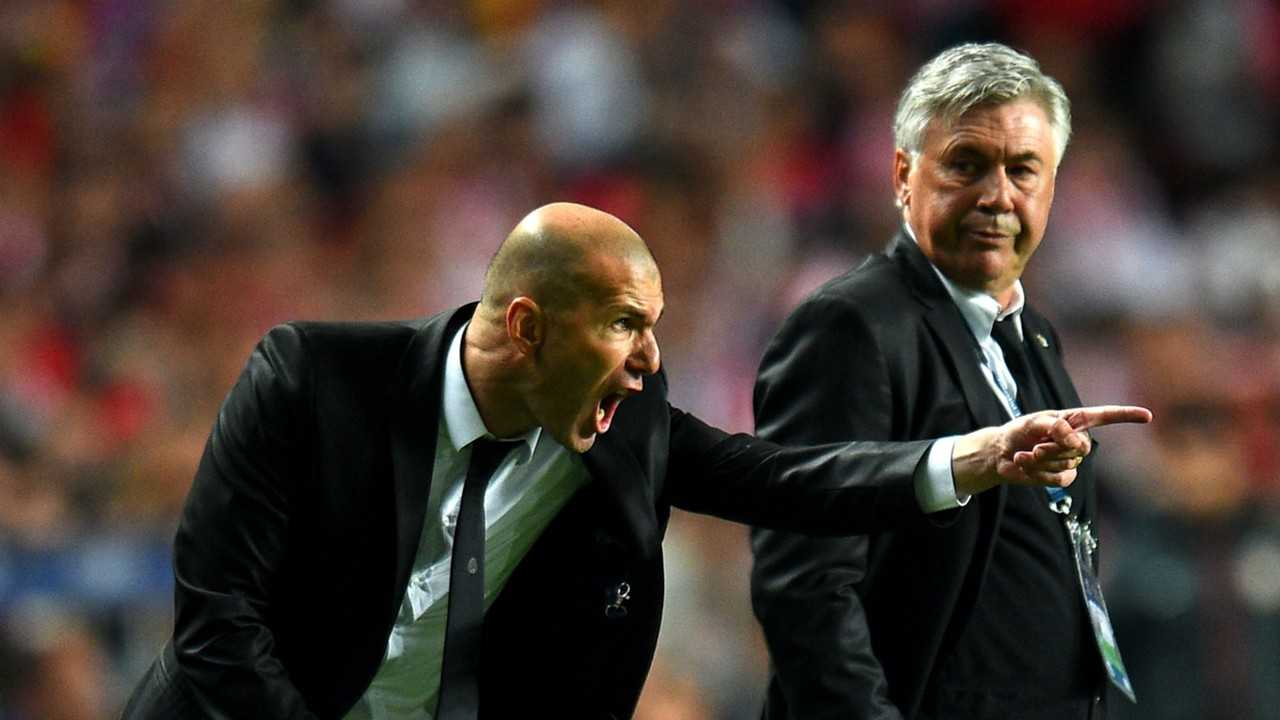

In [9]:
from IPython.display import Image, clear_output, display

display(Image(data='./zidane.jpg', width=500))

In [1]:
from IPython.display import Image, clear_output, display
import cv2, time

def display_image(frame, interval=0.03):
    _, buffer = cv2.imencode('.jpg', frame)
    clear_output(wait=True)
    display(Image(data=buffer, width=500))
    time.sleep(interval)

In [2]:
camera_index = 0
def init_cam(camera_index=camera_index):
    cap = cv2.VideoCapture(camera_index)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)
    cap.set(cv2.CAP_PROP_FPS, 10)

    return cap

In [3]:
def run_camera(duration=5, camera_index=0):
    cap = init_cam(camera_index=camera_index)

    start = time.time()
    while time.time() - start < duration:
        ret, frame = cap.read()
        display_image(frame)

    cap.release()

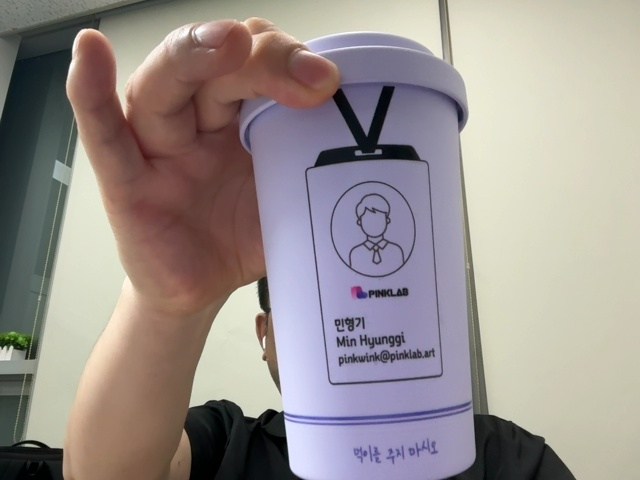

In [4]:
run_camera(duration=5)

In [11]:
def get_edge(frame, threshold1, threshold2):
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(gray_image, threshold1, threshold2)

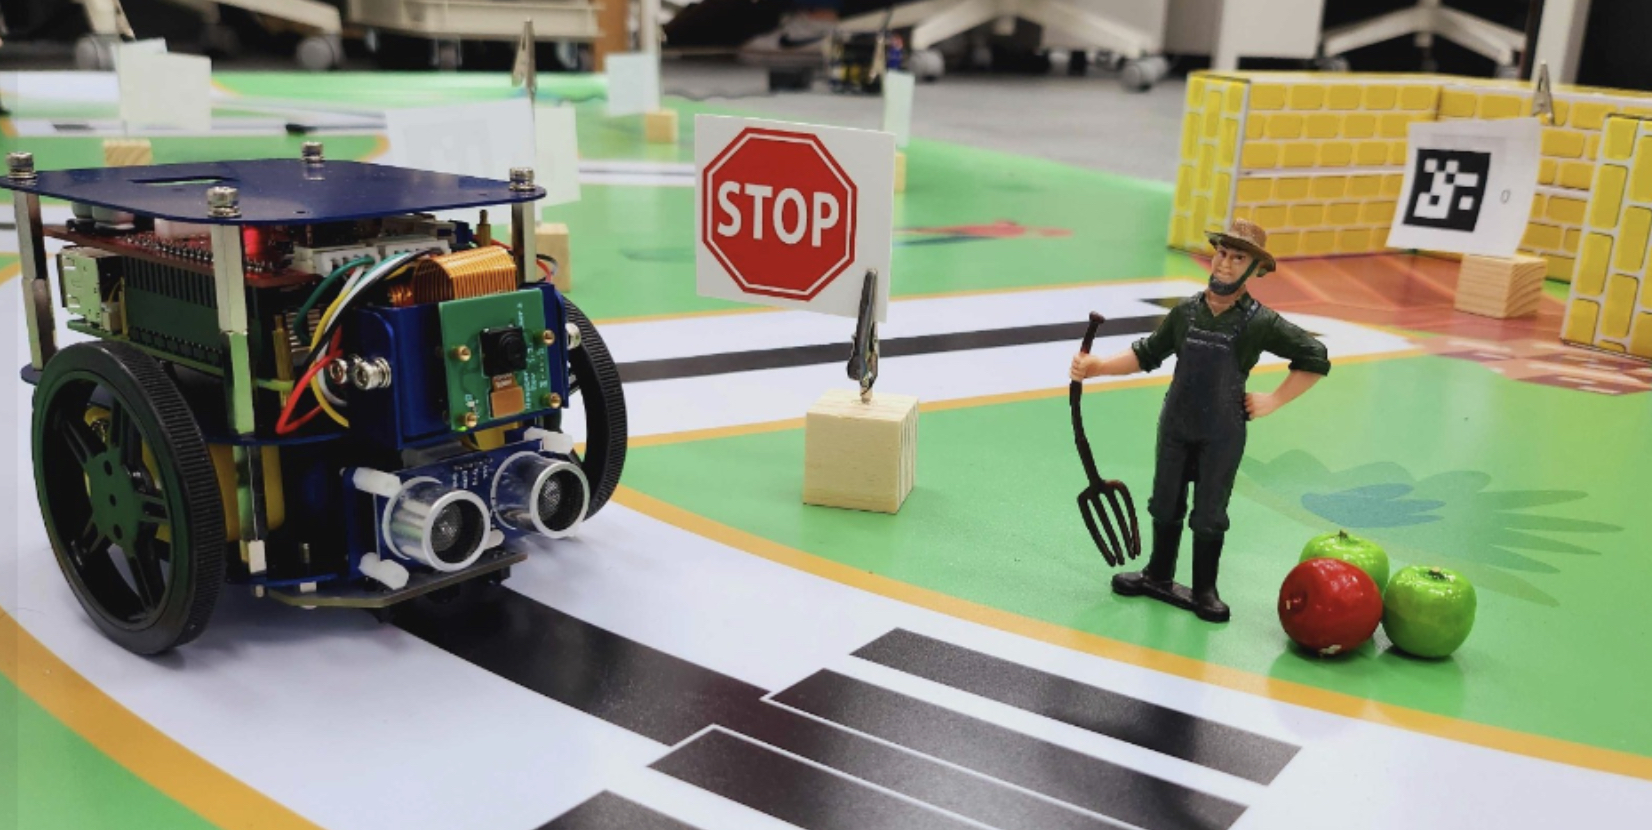

In [ ]:
display(Image(data='./pinky_sample_img.jpg', width=500))

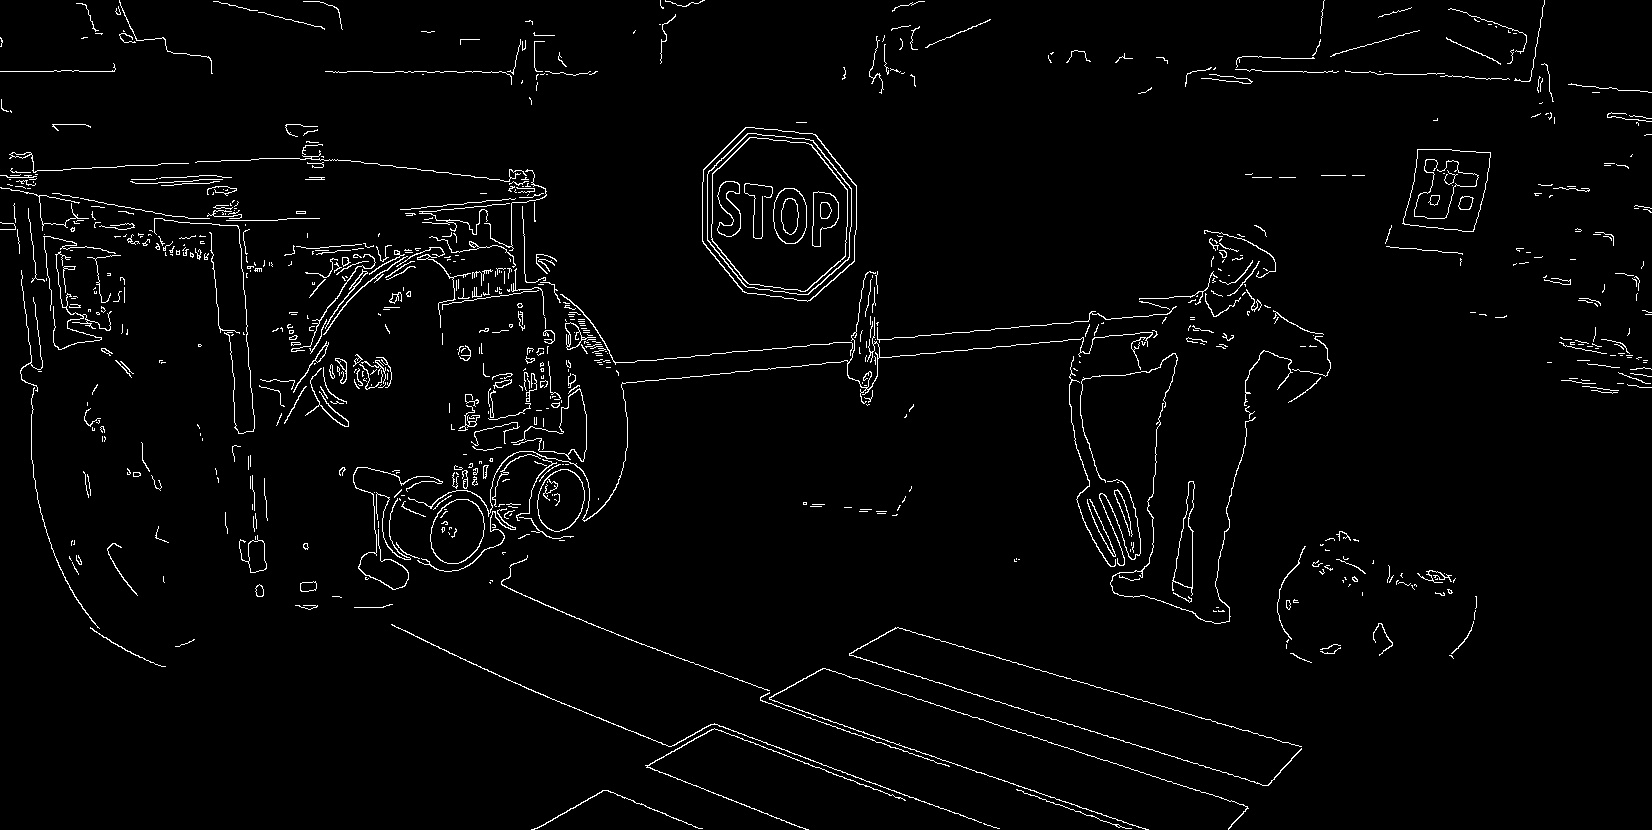

In [22]:
sample = cv2.imread('./pinky_sample_img.jpg')
edge_frame = get_edge(sample, threshold1=150, threshold2=200)
display_image(edge_frame)

In [23]:
def run_edge(duration=5, camera_index=0, threshold1=100, threshold2=150):
    cap = init_cam(camera_index=camera_index)

    start = time.time()
    while time.time() - start < duration:
        ret, frame = cap.read()
        edge_frame = get_edge(frame, threshold1=threshold1, threshold2=threshold2)
        display_image(edge_frame)

    cap.release()

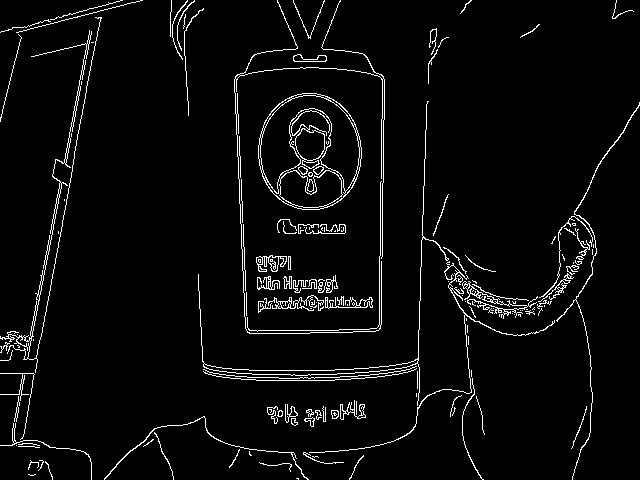

In [24]:
run_edge(threshold1=80, threshold2=150)

In [25]:
import numpy as np

def convert_hsv(frame, ss, vs):
    hsv_image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv_image)

    S = np.clip(S * ss, 0, 255)  # Saturation
    S = np.uint8(S)
    V = np.clip(V * vs, 0, 255)      # Value
    V = np.uint8(V)
    hsv_image = cv2.merge( (H,S,V) )
    
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

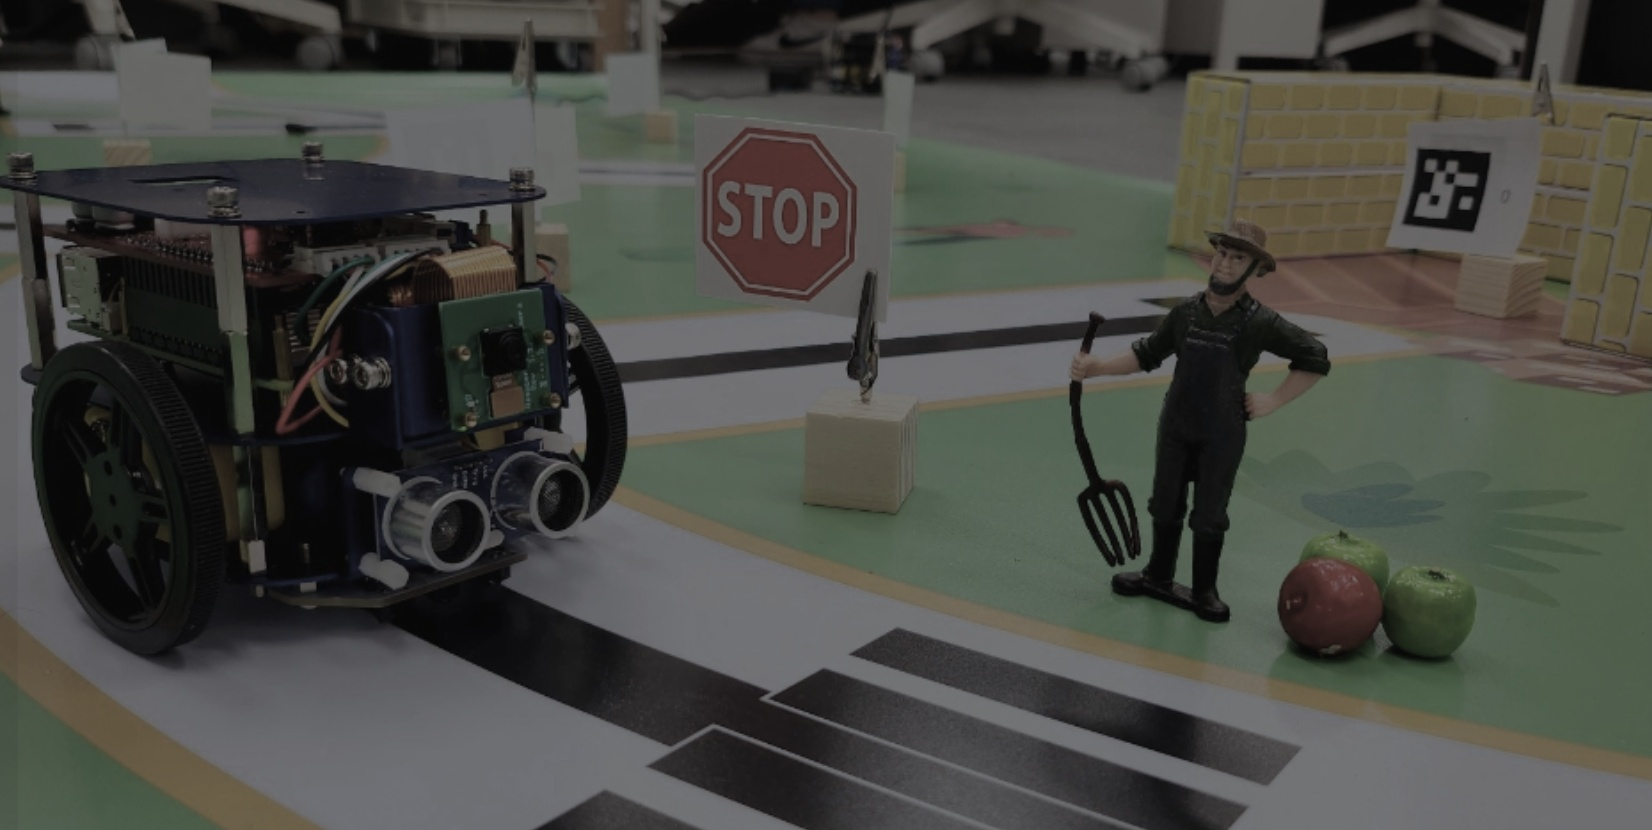

In [27]:
sample = cv2.imread('./pinky_sample_img.jpg')
edge_frame = convert_hsv(sample, ss=0.5, vs=0.5)
display_image(edge_frame)

In [26]:
def run_convert_hsv(duration=5, camera_index=0, saturation_scale=1.0, value_scale=1.0):
    cap = init_cam(camera_index=camera_index)

    start = time.time()
    while time.time() - start < duration:
        ret, frame = cap.read()
        result = convert_hsv(frame, ss=saturation_scale, vs=value_scale)
        display_image(result)

    cap.release()

In [ ]:
run_convert_hsv(saturation_scale=0.5, value_scale=0.5)

In [35]:
def compute_optical_flow(prev_gray, current_gray, pyr_scale=0.5, levels=3,
                            winsize=15, iterations=3, poly_n=5, poly_sigma=1.2):

    flow = cv2.calcOpticalFlowFarneback(
        prev_gray,
        current_gray,
        None,
        pyr_scale,
        levels,
        winsize,
        iterations,
        poly_n,
        poly_sigma,
        0
    )
    return flow

In [36]:
def draw_flow_vectors(frame, flow, step=16, color=(0, 255, 0),
                        thickness=1, tip_length=0.5):

    vis = frame.copy()
    h, w = flow.shape[:2]
    for y in range(0, h, step):
        for x in range(0, w, step):
            fx, fy = flow[y, x]
            end_point = (int(x + fx), int(y + fy))
            cv2.arrowedLine(vis,
                            (x, y),
                            end_point,
                            color=color,
                            thickness=thickness,
                            tipLength=tip_length)
    return vis

In [37]:
def run_optical_flow(duration=5, camera_index=0, pyr_scale=0.5, levels=3,
                        winsize=15, iterations=3, poly_n=5, poly_sigma=1.2, step=16):

    cap = init_cam(camera_index=camera_index)
    prev_gray = None
    start = time.time()

    while time.time() - start < duration:
        ret, frame = cap.read()
        current_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_gray is None:
            prev_gray = current_gray
            continue

        flow = compute_optical_flow(prev_gray, current_gray, pyr_scale=pyr_scale,
                                    levels=levels, winsize=winsize, 
                                    iterations=iterations, poly_n=poly_n, 
                                    poly_sigma=poly_sigma)

        vis = draw_flow_vectors(frame, flow, step=step)

        display_image(vis)
        prev_gray = current_gray

    cap.release()


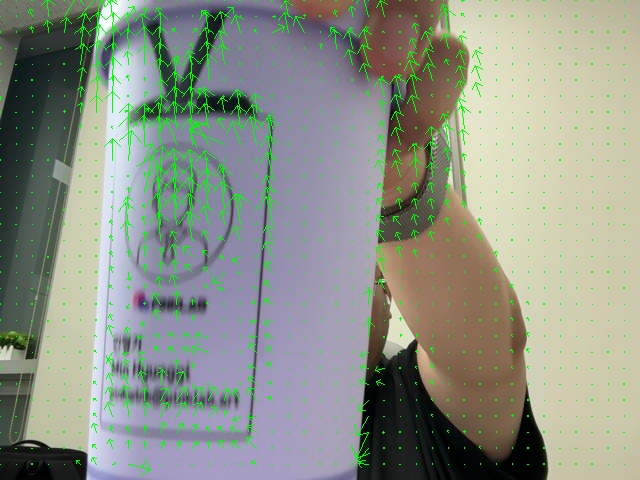

In [39]:
run_optical_flow()